In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

In [3]:
df = pd.read_csv('data/data_combined.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.shape

(2750, 38)

In [4]:
df['Glucose feed [g/min]'] = df['Glucose feed [L/min]'] * 350 # L/min*g/L
df.loc[df['time [h]'] <= 9.9, 'Glucose feed [g/min]'] = param['S0']
df.loc[df['time [h]'] >= 9.9, 'Glucose feed [g/min]'] = df.loc[df['time [h]'] >= 9.9, 'Glucose feed [g/min]'].cumsum()
df['Glucose feed [g/min]'].max()

446.82738712120596

In [5]:
df_na = df.copy().dropna()
df_na.reset_index(inplace=True)
df_na.set_index(pd.Series(range(13)))
df_na.drop(['index'], axis=1, inplace=True)

In [6]:
df_na['Glucose consumed [g/min]'] = df_na['Glucose feed [g/min]'] - (df_na['Glucose [g/L]'] * df_na['Volume [L]']) # if V in L/min then g/min - g/min
df_na['Glucose consumed [g/L]'] = df_na['Glucose consumed [g/min]'] / df_na['Volume [L]']

In [7]:
df_na['mu 1 [1/h]'] = (df_na['Biomass [g/L]'] / df_na['Biomass [g/L]'].shift(1)) / (df_na['time [h]'] - df_na['time [h]'].shift(1))
df_na['mu 12 [1/h]'] = np.log(df_na['Biomass [g/L]'] / df_na['Biomass [g/L]'].shift(1)) / (df_na['time [h]'] - df_na['time [h]'].shift(1))
df_na['mu 2 [1/h]'] = (df_na['Biomass [g/L]'] / df_na['Biomass [g/L]'].iloc[0]) / (df_na['time [h]'] - df_na['time [h]'].iloc[0])
df_na['mu 22 [1/h]'] = np.log(df_na['Biomass [g/L]'] / df_na['Biomass [g/L]'].iloc[0]) / (df_na['time [h]'] - df_na['time [h]'].iloc[0])

In [8]:
df_na['Yxs 1 [gx/gs]'] = (df_na['Biomass [g/L]'] - df_na['Biomass [g/L]'].shift(1)) / (df_na['Glucose [g/L]'] - df_na['Glucose [g/L]'].shift(1))
df_na['Yxs 12 [gx/gs]'] = (df_na['Biomass [g/L]'] - df_na['Biomass [g/L]'].iloc[0]) / (df_na['Glucose [g/L]'] - df_na['Glucose [g/L]'].iloc[0])
df_na['Yxs 2 [gx/gs]'] = (df_na['Biomass [g/L]'] - df_na['Biomass [g/L]'].shift(1)) / (df_na['Glucose consumed [g/L]'] - df_na['Glucose consumed [g/L]'].shift(1))
df_na['Yxs 22 [gx/gs]'] = (df_na['Biomass [g/L]'] - df_na['Biomass [g/L]'].iloc[0]) / (df_na['Glucose consumed [g/L]'] - df_na['Glucose consumed [g/L]'].iloc[0])

In [9]:
df_na['qs 1 [gS/(gXh)]'] = ((df_na['Glucose [g/L]'] - df_na['Glucose [g/L]'].shift(1)) / (df_na['time [h]'] - df_na['time [h]'].shift(1)) / df_na['Biomass [g/L]'])
df_na['qs 2 [gS/(gXh)]'] = ((df_na['Glucose consumed [g/L]'] - df_na['Glucose consumed [g/L]'].shift(1)) / (df_na['time [h]'] - df_na['time [h]'].shift(1)) / df_na['Biomass [g/L]'])
df_na['qs 3 [gS/(gXh)]'] = (df_na['Glucose consumed [g/L]'].diff() / df_na['time [h]'].diff()) / df_na['Biomass [g/L]'].shift(1)

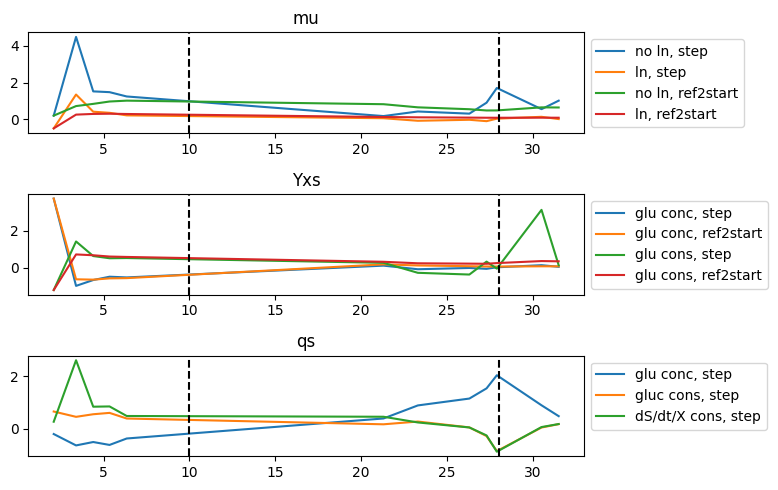

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(8,5))
ax[0].plot(df_na['time [h]'], df_na['mu 1 [1/h]'], label='no ln, step')
ax[0].plot(df_na['time [h]'], df_na['mu 12 [1/h]'], label='ln, step')
ax[0].plot(df_na['time [h]'], df_na['mu 2 [1/h]'], label='no ln, ref2start')
ax[0].plot(df_na['time [h]'], df_na['mu 22 [1/h]'], label='ln, ref2start')
ax[0].legend(bbox_to_anchor=(1.0, 1.0))
ax[0].set_title('mu')
ax[0].axvline(10, color='black', linestyle = '--')
ax[0].axvline(28, color='black', linestyle = '--')

ax[1].plot(df_na['time [h]'], df_na['Yxs 1 [gx/gs]'], label='glu conc, step')
ax[1].plot(df_na['time [h]'], df_na['Yxs 12 [gx/gs]'], label='glu conc, ref2start')
ax[1].plot(df_na['time [h]'], df_na['Yxs 2 [gx/gs]'], label='glu cons, step')
ax[1].plot(df_na['time [h]'], df_na['Yxs 22 [gx/gs]'], label='glu cons, ref2start')
#ax[1].set_ylim(-4,4)
ax[1].legend(bbox_to_anchor=(1.0, 1.0))
ax[1].set_title('Yxs')
ax[1].axvline(10, color='black', linestyle = '--')
ax[1].axvline(28, color='black', linestyle = '--')

ax[2].plot(df_na['time [h]'], df_na['qs 1 [gS/(gXh)]'], label='glu conc, step')
ax[2].plot(df_na['time [h]'], df_na['qs 2 [gS/(gXh)]'], label='gluc cons, step')
ax[2].plot(df_na['time [h]'], df_na['qs 3 [gS/(gXh)]'], label='dS/dt/X cons, step')
ax[2].legend(bbox_to_anchor=(1.0, 1.0))
ax[2].set_title('qs')
ax[2].axvline(10, color='black', linestyle = '--')
ax[2].axvline(28, color='black', linestyle = '--')

plt.tight_layout()
plt.show()

Signal to Noise Ratio: Temperature

In [11]:
df = pd.read_csv('data/data_combined.csv')

In [12]:
# calculating the signal to noise ratio with the mean of the signal, divided by the standard deviation 

signal_amplitude  = np.mean(df['Temperature [°C]'])

temperature_signal = df['Temperature [°C]']
noise_free_portion = 30 #grad

df ['noise'] = df['Temperature [°C]'] - noise_free_portion
noise_std  = np.std(df['noise'])

snr = signal_amplitude / noise_std

df['snr2'] = df['Temperature [°C]']/ noise_std

print(signal_amplitude)
print(noise_std)
print(df['noise'])
print("SNR:", snr)
print("SNR2:",df['snr2'])

29.891307289256197
0.05588558504259951
0      -0.130833
1      -0.136667
2      -0.172500
3      -0.237273
4      -0.179167
          ...   
2745   -0.052500
2746   -0.044167
2747   -0.034545
2748   -0.032500
2749   -0.042727
Name: noise, Length: 2750, dtype: float64
SNR: 534.866142431383
SNR2: 0       534.469965
1       534.365585
2       533.724394
3       532.565370
4       533.605102
           ...    
2745    535.871638
2746    536.020752
2747    536.192911
2748    536.229512
2749    536.046508
Name: snr2, Length: 2750, dtype: float64


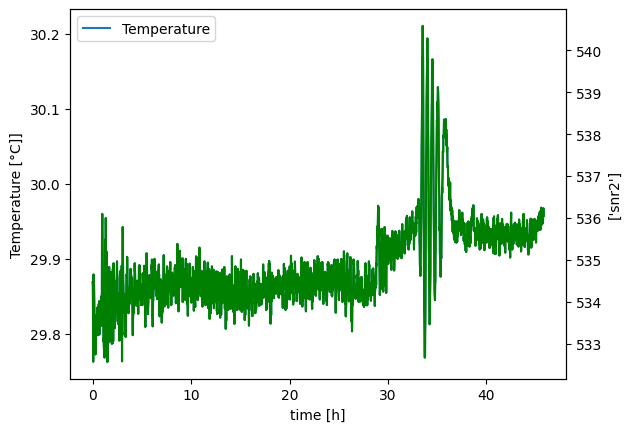

In [13]:
fig, ax = plt.subplots()

ax_sec = ax.twinx()
ax_sec.plot(df['time [h]'],df['snr2'], label=['snr2'], color='green')
ax.plot(df['time [h]'], df['Temperature [°C]'], label='Temperature')

ax.set_xlabel('time [h]')
ax.set_ylabel('Temperature [°C]]')
ax_sec.set_ylabel(['snr2'])

ax.legend()

plt.show()